In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn
from pandas.plotting import scatter_matrix
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from IPython.display import display
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# History

In League of Legends, win prediction is important because it allows players to have a better understanding of their chances of winning a game. By predicting the outcome of a match, players can adjust their gameplay and strategy accordingly, maximizing their chances of success. League of legends is almost 15 years old with a long list of players trying to become the best overtime. Where being high rank can bring prestige, fame and even money sometimes. As the top players can build communites around their ranks

Win prediction is particularly important in ranked play, where players compete against others of similar skill levels to climb the ladder and achieve higher rankings. In this context, every win counts, and being able to accurately predict the outcome of a game can be the difference between gaining or losing valuable ranking points.

Win prediction also helps players identify potential areas of improvement in their gameplay. For example, if a player consistently loses games where win prediction algorithms suggest they should have won, it may be an indication that they need to work on certain aspects of their playstyle, such as decision-making or team coordination.

In summary, win prediction in League of Legends is a valuable tool for players looking to improve their chances of winning games and climbing the rankings. It allows players to adjust their gameplay and identify areas of improvement, ultimately leading to a more rewarding and successful experience in the game.

In [35]:
#Read csv file
df = pd.read_csv("all_participants.csv")

In [36]:
#Drops all values with all columns na value
df_no_nan = df[df.isna().any(axis=1)]
df_no_nan = df_no_nan.dropna(how='all')

In [37]:
df = df.rename(columns={"sumoner_level":"summoner_level"})

In [38]:
#Participants with an id of 1-5 are on the blue side and 6-10 are on the red side
df['side'] = pd.Series('blue', index=df.index).mask(df['participant_id']>5,'red')
#Drops id columns as they have no use in prediction
df = df.drop(columns=['champion_id','item0','item1','item2','item3','item4','item5','item6','team_position','participant_id','id'])
df = df.drop(columns=['item0_name','item1_name','item2_name','item3_name','item4_name','item5_name','item6_name',])
df = df.sort_values('match_id')
df

,match_id,assist,champion_level,champion_name,dmg_to_turrets,deaths,first_blood,first_tower,gold_spend,kills,summoner_level,total_damage,total_damage_taken,minions_killed,turret_kills,win,side
0,NA1_4550653187,6,17,Kassadin,3429,4,0,0,10200,5,197,17669,30284,214,1,0,red
1,NA1_4550653187,4,14,Irelia,850,13,0,0,11750,6,186,17879,30276,179,0,0,red
2,NA1_4550653187,10,14,Swain,1715,4,1,0,8910,6,236,11243,23678,36,5,1,blue
3,NA1_4550653187,7,16,Elise,3742,4,0,0,14025,16,365,39146,31681,22,3,1,blue
4,NA1_4550653187,14,16,Orianna,1531,4,0,0,8600,2,295,11054,15609,178,6,1,blue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,NA1_4595695911,17,17,Kaisa,7873,7,0,0,17105,17,671,43749,25056,186,6,1,red
9995,NA1_4595695911,8,14,Viego,585,10,0,0,11025,6,437,18259,39529,15,0,0,blue
9996,NA1_4595695911,16,12,Thresh,809,13,0,0,7825,3,893,7650,29225,33,2,0,blue
9997,NA1_4595695911,7,16,Sylas,1439,10,0,0,14125,8,315,29502,45043,197,1,0,blue


### Feature definition
match_id: The specific unique id of a match <br>
assist: The amount of kills a player participant contributed to but did not deal the finishing blow <br>
champion_level: The final champion level at the end of the match <br>
champion_name: The name of a champion the player is controlling <br>
dmg_to_turrets: The amount of damage a player did on a turret <br>
deaths: # of deaths at end of match <br>
first_blood: 1 if player got the first kill of the game, 0 otherwise <br>
first_tower: 1 if player destoryed first tower of the game <br>
gold_spend: amount of gold spent in total
kills: # of kills player has
summoner_level: Overall level of player, indicates how many matches the played <br>
total_damage: The total damage a player deals in a match <br>
total_damage_taken: The total damage a player recieves in a match <br>
minions_killed: # of minions killed <br>
turret_kills: # of towers destroyed by player <br>
win: 1 of a player wins the match, 0 otherside <br>
side: The side a player is on, Blue is on the bottom left, red is the top right <br>

# Data exploration

In [39]:
#Calculates the amount of wins for the blue and red side
red_wins = len(df[(df['win']==1) & (df['side']=='red')])
blue_wins = len(df[(df['win']==1) & (df['side']=='blue')])
#Calculates the win rate of the blue and red side
blue_winrate = blue_wins/(len(df)/2)
red_winrate = red_wins/(len(df)/2)
print(f"The Amount of blue wins is {blue_wins} and losses is {len(df)/2} out of {len(df)} participants with winrate of {blue_winrate}")
print(f"The Amount of red wins is {red_wins} and losses is {len(df)/2} out of {len(df)} participants with winrate of {red_winrate}")

The Amount of blue wins is 2445 and losses is 5000.0 out of 10000 participants with winrate of 0.489
The Amount of red wins is 2555 and losses is 5000.0 out of 10000 participants with winrate of 0.511


([<matplotlib.patches.Wedge at 0x1e750dcdac0>,
 [Text(0.03800573103804939, 1.099343242307999, 'Blue side winrate'),
  Text(-0.038005833965991984, -1.0993432387496407, 'Red size winrate')],
 [Text(0.020730398748026936, 0.5996417685316356, '48.9%'),
  Text(-0.020730454890541077, -0.5996417665907131, '51.1%')])

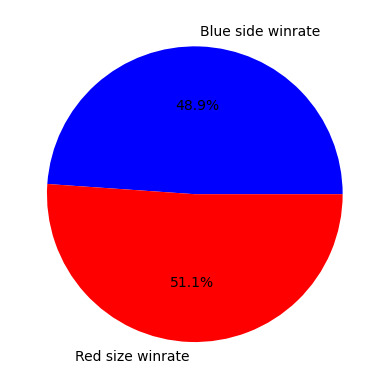

In [40]:
labels = ["Blue side winrate","Red size winrate"]
fig, ax = plt.subplots()
sizes = [blue_winrate,red_winrate]
ax.pie(sizes, labels=labels, autopct='%1.1f%%',colors=['blue','red'])

In League of Legends, the blue and red sides are assigned randomly to teams in each game. While both sides have identical structure layouts, some players argue that the a certain side may have a slight advantage due to its camera angle and placement on the map. In this dataframe, red side has a slighty higher win rate than blue.

In addition, the red side's placement on the map can also be an advantage in certain scenarios. For example, the red side's bottom side has easier access to the dragon pit, a critical objective in the early game. This can make it easier for the red team to contest and secure early dragons, which can give them a significant advantage as the game progresses.

However, it's important to note that any advantage conferred by the red side is relatively small and may be offset by other factors such as individual skill and team composition. Furthermore, statistics suggest that the win rate difference between the blue and red sides is relatively small and varies depending on the region and skill level of players.

Overall, while the red side may have a slight advantage due to its camera angle and placement on the map, it's unlikely to significantly impact win rates in the long run.

### Data manipulation

Current data is that of a participant in a match and not as a team <br>
As league of legends is a team game that requires teamwork to win a match, the match data is altered to into one column


In [41]:
#Creating the columns for the full data
full_data_columns = ['match_id']
#Dropping columns that aren't team related and champion name
match_data = df.drop(columns=['match_id','side','champion_name'])
match_data_columns = match_data.columns.to_numpy()

#Appends ever df feature and tags on the blue team 
for i in range(len(match_data_columns)):
    full_data_columns.append('B' + match_data_columns[i])

#Appends champion played to full_data on blue team
full_data_columns.append('Bchampion1')
full_data_columns.append('Bchampion2')
full_data_columns.append('Bchampion3')
full_data_columns.append('Bchampion4')
full_data_columns.append('Bchampion5')

#Appends ever df feature and tags on the red team 
for i in range(len(match_data_columns)):
    full_data_columns.append('R' + match_data_columns[i])

#Appends champion played to full_data on red team   
full_data_columns.append('Rchampion1')
full_data_columns.append('Rchampion2')
full_data_columns.append('Rchampion3')
full_data_columns.append('Rchampion4')
full_data_columns.append('Rchampion5')


In [42]:
#Groups data by match and side to retrieve sum of participate data based on match and side
# Data is first grouped by match_id and then side. Therefore the resulting dataframe has the match_id first and then blue side
# Followed by the red team data below
team_data = df.groupby(['match_id','side']).sum().to_numpy()
#Gets list of champion played in a match by each side
champion_list = df.groupby(['match_id','side'])['champion_name'].apply(list)
#Gets every match in the dataframe
matches_list = pd.unique(df['match_id'])

full_data = []
i = 0
l = 0

while i < len(team_data):
    #Creates current match data 
    current_data = [matches_list[l]]
    l += 1
    #Appends Blue side data to current match data
    for j in range(len(match_data_columns)):
        current_data.append(team_data[i][j])
    
    #Appends blue side champions to current match data
    for k in range(len(champion_list[i])):
        current_data.append(champion_list[i][k])
    i += 1
    
    #Appends red side data to current match data
    for j in range(len(match_data_columns)):
        current_data.append(team_data[i][j])
    
    #Appends red side champions to current match data
    for k in range(len(champion_list[i])):
        current_data.append(champion_list[i][k])
        
    i += 1
    #Appends current match data to full data
    full_data.append(current_data)

#Creates new dataframe
full_data = pd.DataFrame(full_data,columns=full_data_columns)
full_data['Rwin'] = full_data['Rwin']/5
full_data = full_data.drop(columns=['Bwin','match_id'])

In [43]:
#Visualising distribution of some features

#Using pandas scatter matrix to plot each columns against each other to view negative and positive correlation
#RAD: Red team assist difference
#RCLD: Red team champion level difference
#RDTD: Red team damage to turret difference
#RDD: Red team deaths difference
#RFBD: Red  team first blood difference
#RTFT: Red team first tower difference
#RGSD: Red team golds spend difference
#RKD: Red team kills difference
#RSLD: Red team summoner level difference
#RTDD: Red team total damage given difference
#RTDTD: Red team total damage taken difference
#RMKD: Red team minions killed difference
#RTKD: Red team turret kills difference
full_data['RAD'] = full_data['Rassist'] - full_data['Bassist']
full_data['RCLD'] = full_data['Rchampion_level'] - full_data['Bchampion_level']
full_data['RDTD'] = full_data['Rdmg_to_turrets'] - full_data['Bdmg_to_turrets']
full_data['RDD'] = full_data['Rdeaths'] - full_data['Bdeaths']
full_data['RFBD'] = full_data['Rfirst_blood'] - full_data['Bassist']
full_data['RFTD'] = full_data['Rfirst_tower'] - full_data['Bfirst_tower']
full_data['RGSD'] = full_data['Rgold_spend'] - full_data['Bgold_spend']
full_data['RKD'] = full_data['Rkills'] - full_data['Bkills']
full_data['RSLD'] = full_data['Rsummoner_level'] - full_data['Bassist']
full_data['RTDD'] = full_data['Rtotal_damage'] - full_data['Btotal_damage']
full_data['RTDTD'] = full_data['Rtotal_damage_taken'] - full_data['Btotal_damage_taken']
full_data['RMKD'] = full_data['Rminions_killed'] - full_data['Bminions_killed']
full_data['RTKD'] = full_data['Rturret_kills'] - full_data['Bturret_kills']

## Data processing

In [44]:
#Creating new dataframe with the full_data index to hold categorical variables
new_df = pd.DataFrame(index=full_data.index)
#iterates through the columns and their data
for col, col_data in full_data.iteritems():
    # If a column's value data type is a string, a categorical variable
    if col_data.dtype == object:
        #Coverts data into a dummy variable
        col_data = pd.get_dummies(col_data, prefix=col)
        
    # Joins the new dataframe with the dummy variables and others    
    new_df = new_df.join(col_data)

In [45]:
feature, target = new_df.drop(columns=['Rwin']), full_data['Rwin'],
X_train, X_test, y_train, y_test = train_test_split(
   feature, target, test_size = 0.3, random_state = 1
)
feature

,Bassist,Bchampion_level,Bdmg_to_turrets,Bdeaths,Bfirst_blood,Bfirst_tower,Bgold_spend,Bkills,Bsummoner_level,Btotal_damage,...,RDD,RFBD,RFTD,RGSD,RKD,RSLD,RTDD,RTDTD,RMKD,RTKD
0,55,78,24555,26,1,1,59085,43,1782,117138,...,17,-55,-1,-9285,-18,1164,-26758,6391,21,-23
1,17,67,5127,33,1,0,44850,19,825,65264,...,-14,-17,1,8035,14,2006,36218,-19975,-17,14
2,53,83,21766,26,1,1,64720,35,1109,121869,...,9,-53,-1,-4670,-9,1586,9097,-21590,-48,-15
3,42,62,12821,14,0,1,38925,30,1245,77342,...,16,-41,-1,-5415,-16,987,-8921,-3940,13,-14
4,35,77,11545,41,1,0,56664,24,1765,85507,...,-17,-35,1,4186,17,1314,56516,-43073,59,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,51,77,19627,21,0,0,50135,29,1896,102218,...,8,-50,0,-575,-8,2264,-8721,-1140,80,-17
996,71,88,19930,29,1,1,69900,34,1566,143884,...,5,-71,-1,1905,-5,1688,-165,-21226,-5,-5
997,32,71,10831,37,0,1,54600,18,2120,98175,...,-18,-31,-1,-1055,19,1975,15317,-11742,-126,6
998,7,49,741,24,0,0,23700,5,1976,27150,...,-19,-6,0,9635,19,1195,13561,-8075,5,2


## Machine Learning

### logistic regression

In [46]:
log_model = LogisticRegression(random_state=11, max_iter=10000)
log_model1 = log_model.fit(X_train, y_train)
y_pred_average = log_model.predict(X_test)
print("Training set score: {:.3f}".format(log_model1.score(X_train,y_train)))
print("Test set score: {:.3f}".format(log_model1.score(X_test,y_test)))

Training set score: 0.984
Test set score: 0.967


C:\Users\Thinh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Support vector machine

In [47]:
svc_model = SVC(random_state=912, kernel='rbf')
svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)
print("Training set score: {:.3f}".format(svc_model.score(X_train,y_train)))
print("Test set score: {:.3f}".format(svc_model.score(X_test,y_test)))

Training set score: 0.943
Test set score: 0.917


### Multilayer perceptron

In [48]:
mlp = MLPClassifier(random_state = 10, max_iter = 5000, activation = 'relu',hidden_layer_sizes = (3,2),alpha = 0.0001)
mlp1 = mlp.fit(X_train, y_train)
y_pred_average = mlp.predict(X_test)
print("Training set score: {:.3f}".format(mlp1.score(X_train,y_train)))
print("Test set score: {:.3f}".format(mlp1.score(X_test,y_test)))

Training set score: 0.759
Test set score: 0.780


### XGB boost

In [49]:
xgb_classifier = xgb.XGBClassifier(n_estimators=100, objective='binary:logistic', tree_method='hist', eta=0.1, max_depth=3)
xgb_classifier.fit(X_train, y_train)
y_pred_average = xgb_classifier.predict(X_test)
print("Training set score: {:.3f}".format(xgb_classifier.score(X_train,y_train)))
print("Test set score: {:.3f}".format(xgb_classifier.score(X_test,y_test)))

Training set score: 1.000
Test set score: 0.977


In this dataset, xgb classiffier is the most accurate win prediction machine learning algorithm at a score of 0.973

XGBoost (Extreme Gradient Boosting) is a powerful machine learning algorithm for several reasons such as

High Accuracy: XGBoost has been proven to be highly accurate in a wide range of applications, including regression, classification, and ranking. It is especially good at handling structured data, making it an ideal algorithm for many real-world business problems.

Fast and Scalable: XGBoost is designed to be very fast and scalable, making it an ideal algorithm for large datasets. It can handle millions of examples and thousands of features in a relatively short amount of time, even on a single machine.

Regularization: XGBoost incorporates L1 and L2 regularization, which helps prevent overfitting and improves the generalization of the model. This means that the model is less likely to memorize the training data and more likely to perform well on unseen data.

Feature Importance: XGBoost provides a measure of feature importance, which can be used to identify the most relevant features for a given problem. This can be very useful for feature selection and feature engineering.

Flexibility: XGBoost is a highly flexible algorithm that can be customized for specific applications. It supports custom loss functions and evaluation metrics, as well as different optimization objectives and learning rates.

Overall, XGBoost is a highly effective algorithm that is well-suited for many machine learning tasks. Its combination of high accuracy, speed, and flexibility make it a popular choice among data scientists and machine learning practitioners.

In [50]:
dmatrix = xgb.DMatrix(data=feature, label=target) #Learning API uses a dmatrix
params = {'objective':'reg:squarederror'}
cv_results = xgb.cv(dtrain=dmatrix, 
                    params=params, 
                    nfold=10, 
                    metrics={'rmse'})
print('RMSE: %.2f' % cv_results['test-rmse-mean'].min())

RMSE: 0.15


In [51]:
print(classification_report(y_test, y_pred_average))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       151
         1.0       0.97      0.98      0.98       149

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



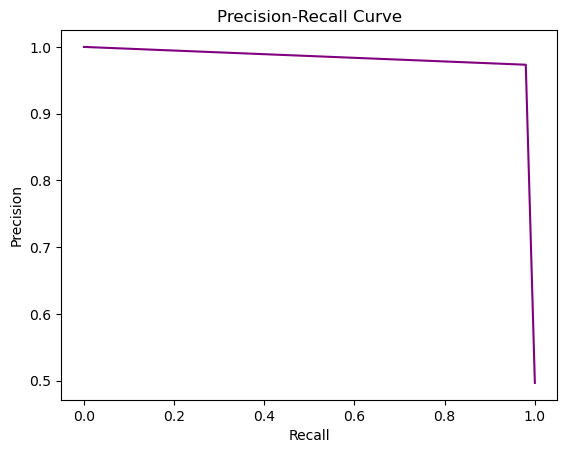

In [52]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_average)
fig, ax = plt.subplots()
ax.plot(recall, precision, color= 'purple')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()